In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [2]:
H,W = 400,400
f = 1200

u,v = np.arange(W), np.arange(H)
u,v = np.meshgrid(u,v)

rays_o = np.zeros((H*W, 3))
rays_d = np.stack((
    (u - W/2),
    -(v - H/2),
    -f * np.ones_like(u)
), axis=-1)

rays_d = rays_d / np.linalg.norm(rays_d, axis=-1, keepdims=True)
rays_d = rays_d.reshape(-1, 3)

rays_o = torch.Tensor(rays_o)
rays_d = torch.Tensor(rays_d)

In [3]:
class Sphere():
    def __init__(self, radius = 1, center = (0,0,0), color = (1,0,0), density= 10) -> None:
        self.radius  = radius
        self.center  = torch.Tensor(center)
        self.color   = torch.Tensor(color)
        self.density = density
        
    def intersect(self, X):
        """
        X [N,3]: 3D points of the space.
        """
        
        N = X.shape[0]
        colors    = torch.zeros((N,3))
        densities = torch.zeros((N,1))

        cond = ( (X[:,0] - self.center[0])**2 + (X[:,1] - self.center[1])**2 + (X[:,2] - self.center[2])**2 ) <= self.radius**2

        colors[cond]    = self.color
        densities[cond] = self.density
        
        return colors, densities

In [4]:
def compute_accumulated_transmittance(b):
    acc = torch.cumprod(b, 1)
    acc[:,0] = 1.
    return acc
    
def render(model, rays_o, rays_d, tn=0.2, tf=1.2, ND=100):
    rays_o = torch.Tensor(rays_o)
    rays_d = torch.Tensor(rays_d)
    
    t  = torch.linspace(tn,tf, ND)
    dt = torch.cat((t[1:]-t[:-1], torch.Tensor([1e10])))

    X = rays_o.unsqueeze(1) + t.unsqueeze(0).unsqueeze(-1) * rays_d.unsqueeze(1)
    
    colors,densities = model.intersect(X.reshape(-1,3))
    
    colors = colors.reshape(-1, ND, 3)
    densities = densities.reshape(-1, ND)

    alphas = 1 - torch.exp(- densities * dt.unsqueeze(0))
    T = compute_accumulated_transmittance(1-alphas)
    
    color = (T.unsqueeze(-1) * alphas.unsqueeze(-1) * colors).sum(axis=1)
    return color

In [5]:
s1 = Sphere(radius=0.1, center=(0.,0,-1),color=(1,0,0))
color = render(s1, rays_o, rays_d)
color = color.reshape(H,W,3).numpy()

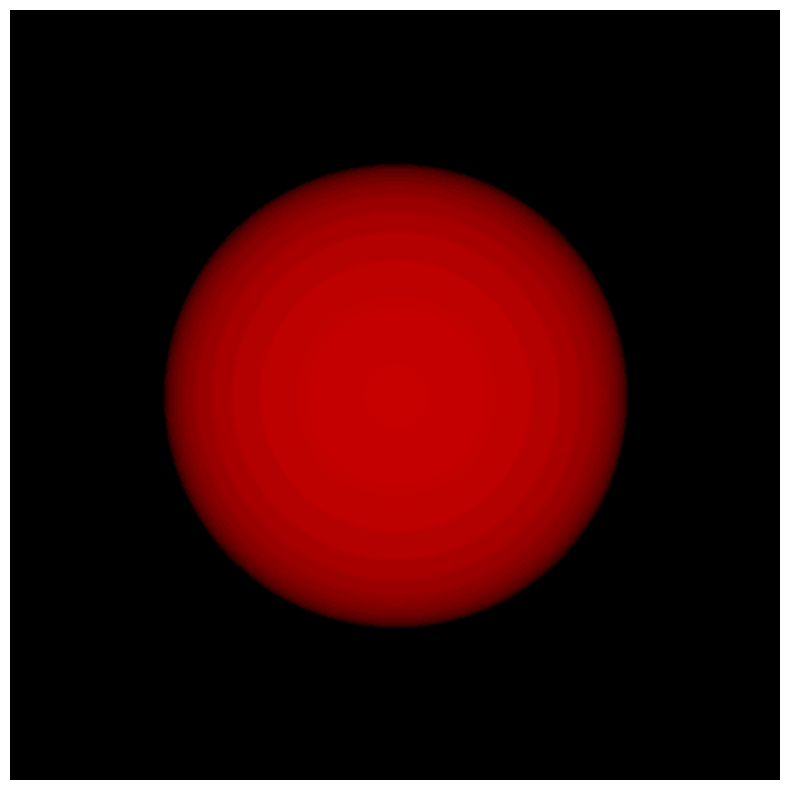

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(color)
plt.axis("off")
plt.show()